In [10]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.metrics import classification_report, confusion_matrix
from logging import getLogger
import seaborn as sns
import matplotlib.pyplot as plt

from src.models.utils import callbacks
from src.preprocessing.computer_vision import augmentation, scaling
from src.projects.eurosat.architecture import FCNNetwork, CNNNetwork

In [11]:
_log = getLogger()
model_save_fp = Path(os.getcwd()) / Path('trained_models') / Path('eurosat')

In [12]:
train_dataset, validation_dataset, test_dataset = tfds.load(
    "eurosat/rgb", as_supervised=True, split=["train[:80%]", "train[80%:90%]", "train[90%:]"]
)
_, info = tfds.load(
    "eurosat/rgb", as_supervised=True, with_info=True,
)

In [13]:
# Labels
class_names = info.features["label"].names
print(class_names)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Plotting some random images with their label

In [14]:
def plot_random_images(dataset: tf.data.Dataset, sample_size :int):
    random_images = []
    sqrt_sample = int(np.sqrt(sample_size))

    for el in dataset.shuffle(1000).take(sqrt_sample*sqrt_sample):
        image, label = el
        label_name = class_names[label.numpy()]
        random_images.append((label_name, image))

    fig, axs = plt.subplots(nrows=sqrt_sample, ncols=sqrt_sample, figsize=(12, 12))
    plt.subplots_adjust(hspace=0.5)
    fig.suptitle("Sample Images", fontsize=14, y=0.95)

    for img_tuple, ax in zip(random_images, axs.ravel()):
        label, img = img_tuple
        ax.imshow(img)
        ax.set_title(label)
    plt.show()


2022-12-02 11:39:23.908275: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


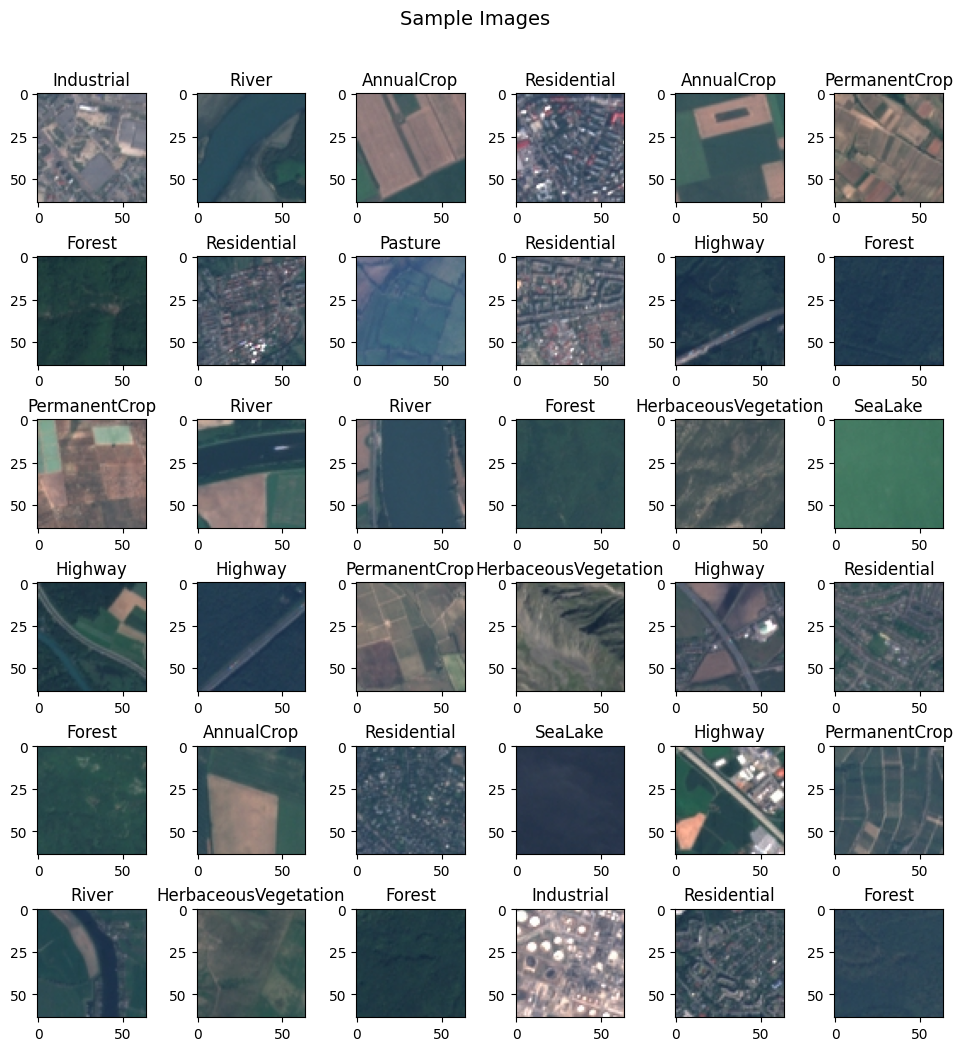

In [15]:
plot_random_images(train_dataset, 36)

The next steps will be about preprocessing the images: we will randomly flip them, adjust the brightness and the contrast. Since all images have the same size we don't need to crop or resize them

2022-12-02 11:39:27.098128: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


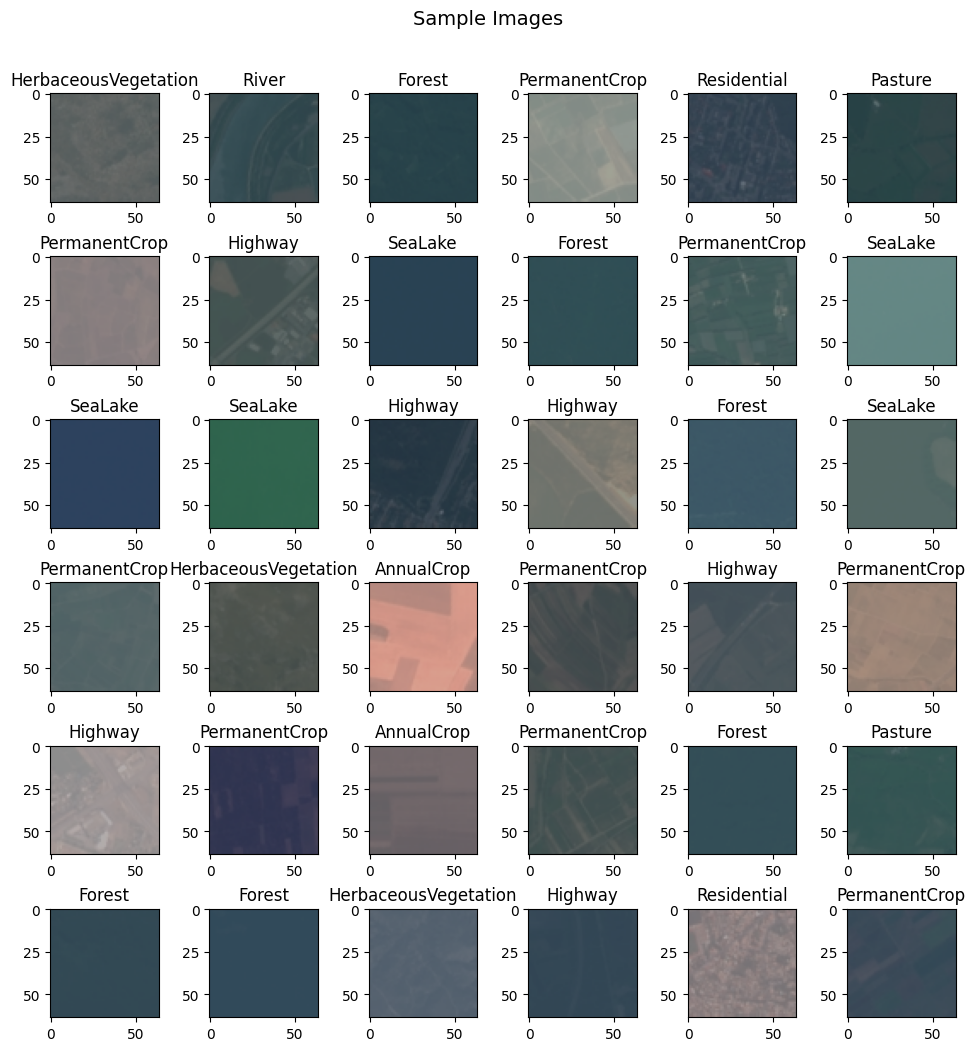

In [16]:
train_dataset = train_dataset.map(lambda image, label: (augmentation(image), label))
plot_random_images(train_dataset, 36)
train_dataset = train_dataset.map(lambda image, label: (scaling(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (augmentation(image), label))
validation_dataset = validation_dataset.map(lambda image, label: (scaling(image), label))

In [17]:
batch_size = 32
train_dataset = train_dataset.shuffle(2000, reshuffle_each_iteration=True).repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [18]:
name = 'CNNNetwork'
artifacts_path = model_save_fp / Path(name)
model = CNNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(),
    steps_per_epoch=600,
    validation_steps=600,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")

ValueError: The last dimension of the inputs to a Dense layer should be defined. Found None. Full input shape received: (None, None)

In [ ]:
name = 'FCNNetwork'
artifacts_path = model_save_fp / Path(name)
model = FCNNetwork(name=name, filepath=artifacts_path)
model = model.connect_layers()
epochs = 100
model.fit(
    x=train_dataset, 
    validation_data=validation_dataset, 
    epochs=epochs, 
    callbacks=callbacks(),
    steps_per_epoch=600,
    validation_steps=600,
)
model.save(artifacts_path)
_log.info(f"Saved {model.name} in folder {artifacts_path}")